In [28]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

## Model creation

In [29]:
# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run simulation
real_parameters = [0.1, 0.5, 3]

times = np.linspace(0, 20, 200)
org_values = model.simulate(real_parameters, times)

# take 5-10% of range as standard deviation for normally distributed noise
noise_range_percent = 0.05
noise_stds = (org_values.max(axis=0) - org_values.min(axis=0)) * noise_range_percent

# Add noise
values = org_values + np.random.normal(0, noise_stds, org_values.shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

In [30]:
bounds = pints.Boundaries(lower = [0, 0, 2], upper = [1, 1, 4])
log_prior = pints.UniformLogPrior(bounds)

In [31]:
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)
likelihoods[:5]

array([-16475.16838195,  -3613.40814264, -15329.26320638,  -7115.17503022,
       -23751.39751601])

In [32]:
input_parameters[:5]

array([[0.54024432, 0.20195299, 3.45155059],
       [0.39774192, 0.39632852, 2.05766421],
       [0.60660735, 0.32513452, 2.92238082],
       [0.18250105, 0.35838443, 2.28209116],
       [0.85584693, 0.02303377, 3.89944255]])

In [9]:
emu = emupints.GPEmulator(real_log_likelihood, input_parameters, likelihoods, normalize_input = True)

# Plotting surfaces for fixed parameters

In [10]:
# number of splits for each parameter in the surface
n_splits = 50

# each entry is a list of parameters that should be fixed
fixed_parameters = [
    [(0, 0.1)], # a = 0.1, 0.5, 1
    [(0, 0.5)], 
    [(0, 1)],
    [(1, 0.1)], # b = 0.1, 0.5, 1
    [(1, 0.5)], 
    [(1, 1)],
    [(2, 2)], # c = 2, 3, 4
    [(2, 3)], 
    [(2, 4)]
]

grid_shape = (3, 3)

# number of splits for each parameter in the surface
index_to_param_name = {
    0 : "a",
    1 : "b",
    2 : "c"
}

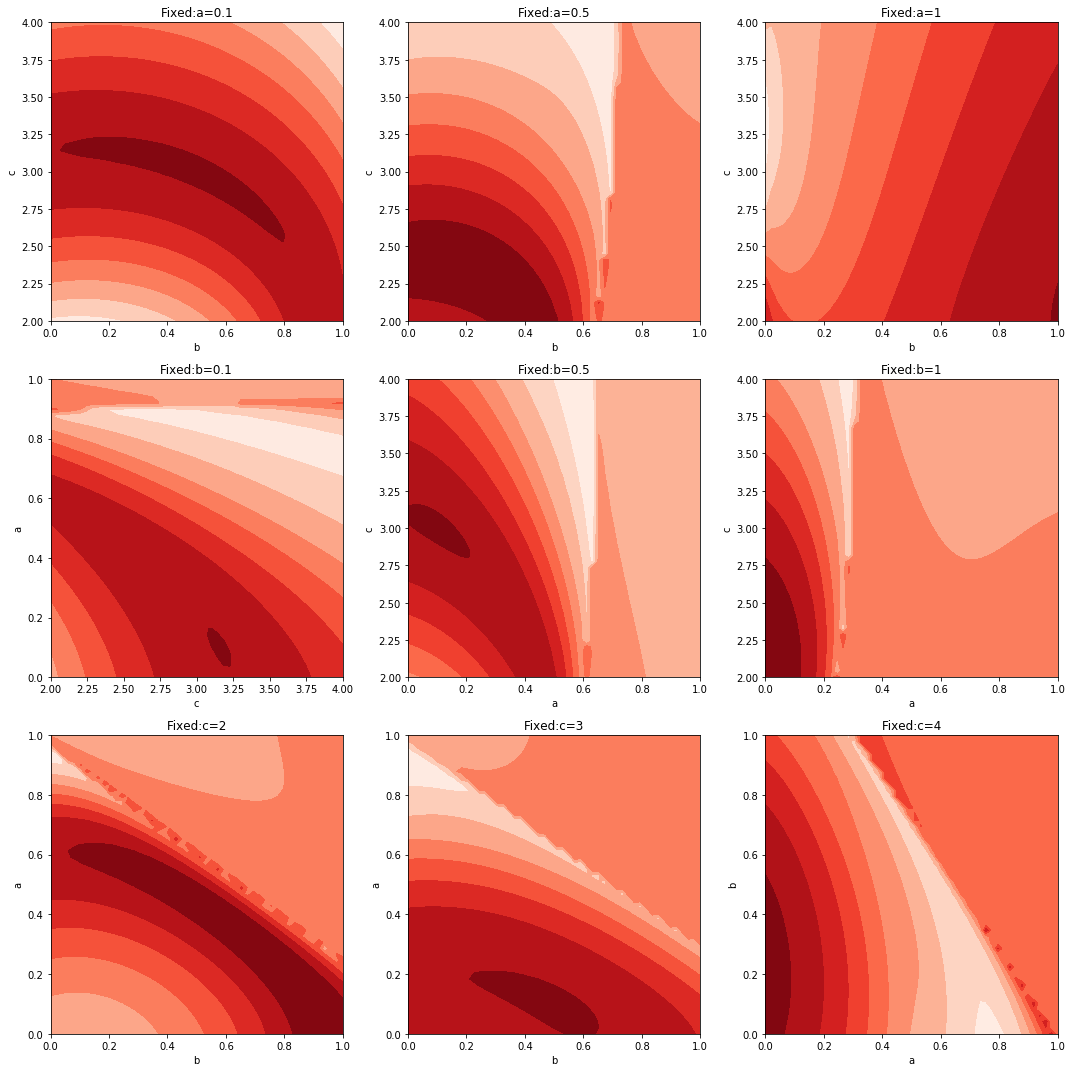

In [11]:
fig, axes = emuplt.plot_fixed_param_grid( 
    real_log_likelihood, 
    fixed_parameters, 
    bounds,
    index_to_param_name=index_to_param_name,
    shape = (3, 3),
    contour = True
)

plt.show(fig)

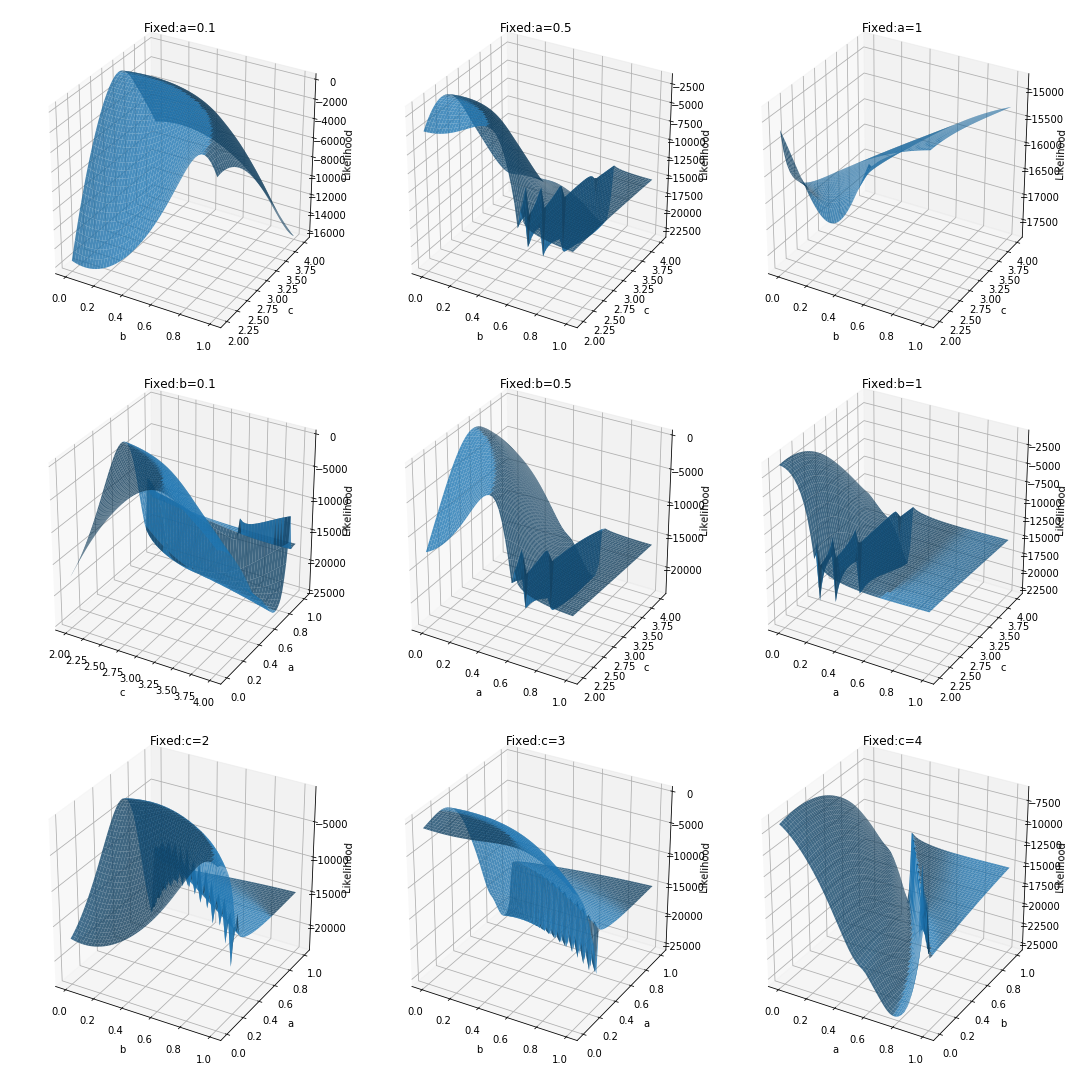

In [12]:
fig, axes = emuplt.plot_fixed_param_grid(real_log_likelihood, 
                                         fixed_parameters,
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         shape = (3, 3),
                                         contour = False
                              )
plt.show(fig)

# Kernel selection

In [13]:
n_parameters = emu.n_parameters()
kernels = [
    GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters),
    GPy.kern.MLP(n_parameters),
    GPy.kern.Matern52(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.Matern52(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) + GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters),
    GPy.kern.RBF(n_parameters, lengthscale=2) * (GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(n_parameters)),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) + 
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters),
]

kern_names = [
    "RBF",
    "RatQuad",
    "MLP",
    "Matern52",
    "RatQuad + RBF*RBF",
    "Matern52 + RBF*RBF",
    "RatQuad + RBF + RBF",
    "RatQuad + RatQuad + RatQuad",
    "PeriodicExp + RatQuad + RBF*RBF",
    "RBF + PeriodicMatern52 + MLP",
    "RatQuad + RBF + RatQuad + RBF"
    # Gibbs kernel
]

#optimizer = "scg"
#emu.set_parameters(optimizer = optimizer)

In [14]:
marginal_likelihoods = []

for kern, name in zip(kernels, kern_names):
    # TODO: Test with white noise
    kern += GPy.kern.White(n_parameters)
    emu.set_parameters(kernel = kern)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = 500, messages = False)
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(name, ml))

RBF: 445.47
RatQuad: 563.53
MLP: 675.61
Matern52: 548.63
RatQuad + RBF*RBF: 580.58
Matern52 + RBF*RBF: 579.96
RatQuad + RBF + RBF: 580.58
RatQuad + RatQuad + RatQuad: 563.53
PeriodicExp + RatQuad + RBF*RBF: 585.49
RBF + PeriodicMatern52 + MLP: 580.58


In [15]:
best_kern = kernels[np.argmax(marginal_likelihoods)]
print(best_kern)

  mlp.             |  value  |  constraints  |  priors
  variance         |    1.0  |      +ve      |        
  weight_variance  |    1.0  |      +ve      |        
  bias_variance    |    1.0  |      +ve      |        


In [16]:
# choose kern that in addition to good marginal log likelihood has small variances in parameters
emu.set_parameters(kernel = kernels[5])
emu.fit(normalizer = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s60  0007  -5.190237e+02   3.069539e+03 
    25s51  0019  -5.660036e+02   4.937753e+03 
    37s79  0029  -5.787807e+02   1.255872e+03 
    47s66  0037  -5.799632e+02   1.502728e-06 
Runtime:     47s66
Optimization status: Converged



In [17]:
emu.get_gp()

GP_regression.,value,constraints,priors
sum.Mat52.variance,0.06618180777698991,+ve,
sum.Mat52.lengthscale,0.39967389122815505,+ve,
sum.mul.rbf.variance,0.8169716967588323,+ve,
sum.mul.rbf.lengthscale,1.510032158933166,+ve,
sum.mul.rbf_1.variance,0.8169716967588323,+ve,
sum.mul.rbf_1.lengthscale,1.510032158933166,+ve,
Gaussian_noise.variance,0.01338182802731039,+ve,


 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


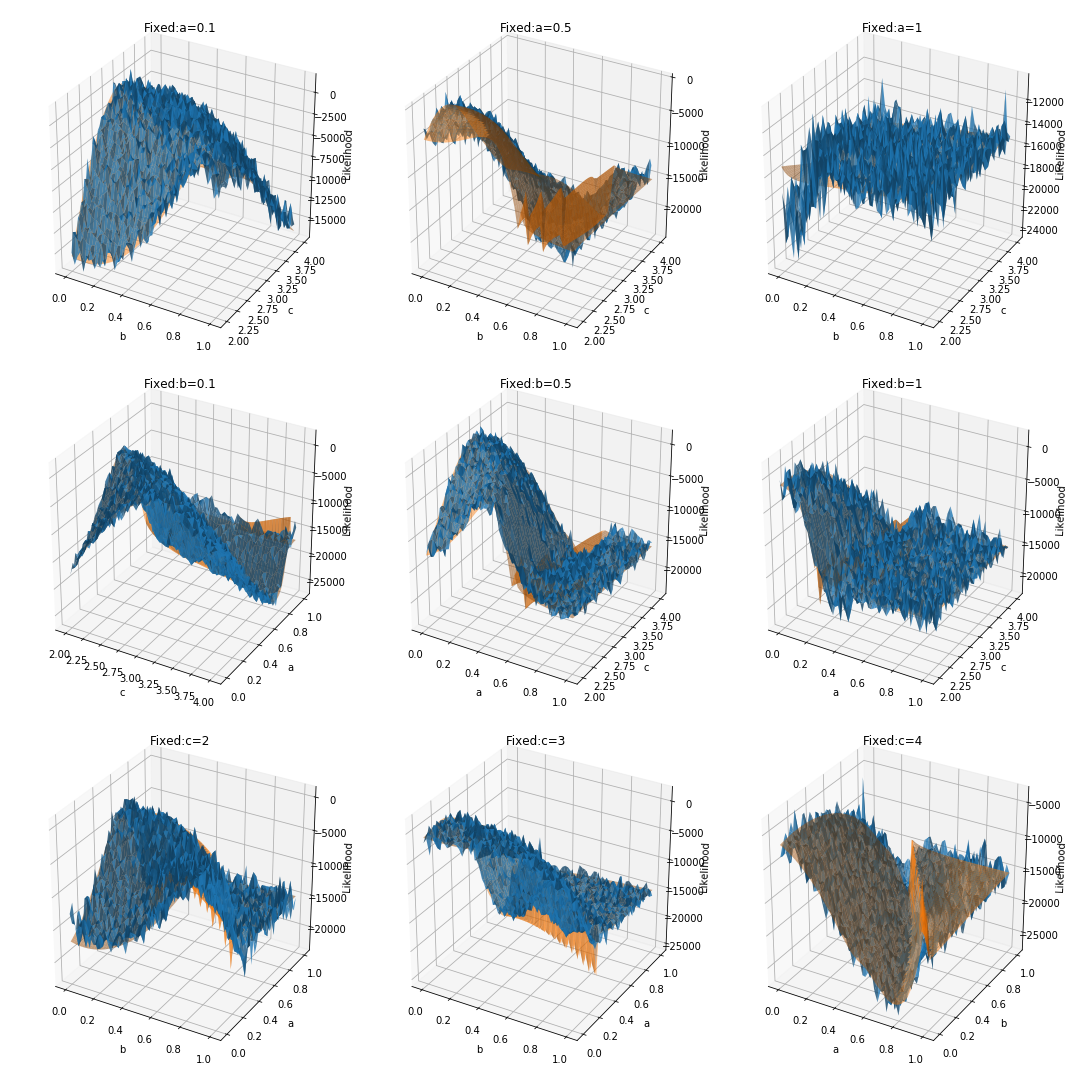

In [18]:
fig, axes = emuplt.plot_fixed_param_grid(emu, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         contour = False,
                                         shape = (3, 3),
                                         additional_log_likelihoods = [real_log_likelihood]
)

 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


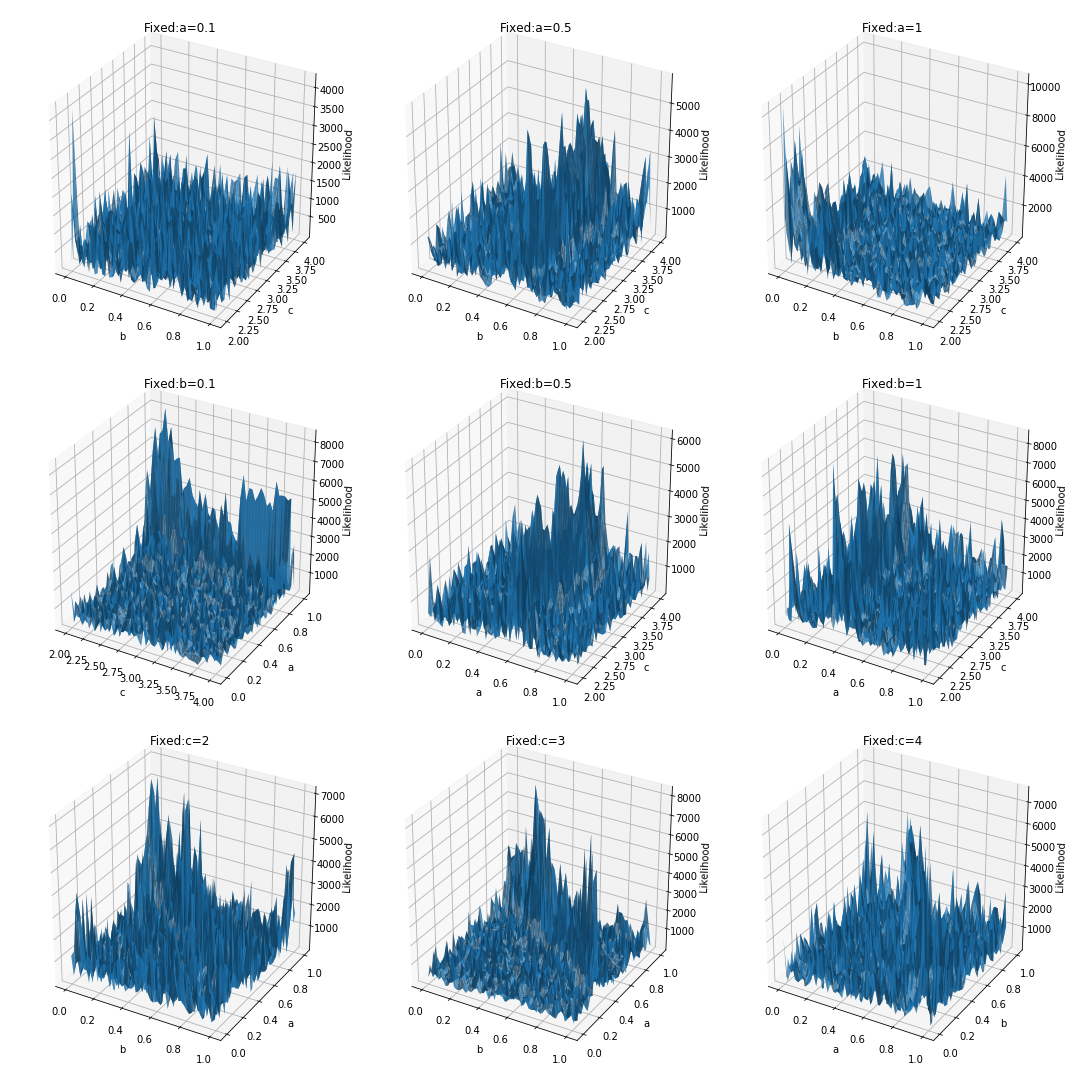

In [19]:
difference_likelihood = lambda x: np.abs(emu(x) - real_log_likelihood(x))
fig, axes = emuplt.plot_fixed_param_grid(difference_likelihood, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         shape = (3, 3),
                                         contour = False,
                                 )

## Timing single prediction

In [20]:
# Model : Time to execute vs number of times (expect to be close to linear?)
# Emulator : Time to execute vs number of training points 
import time

In [21]:
def find_eval_time(func, prior, iters = 10000):
    t_start = time.time()
    for _ in range(iters):
        func(prior.sample(1)[0])
    t_end = time.time()
    return (t_end - t_start) / iters

In [22]:
# Run a simulation
time_splits = [100] + [1000 * i for i in range(1, 21)]
parameters = [0.1, 0.5, 3]
exec_times = []

for time_split in time_splits:
    # Create a log-likelihood function but with more times given
    times = np.linspace(0, 20, time_split)
    org_values = model.simulate(parameters, times)
    values = org_values + np.random.normal(0, noise, org_values.shape)
    problem = pints.MultiOutputProblem(model, times, values)
    log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)
    
    exec_t = find_eval_time(log_likelihood, log_prior, iters = 5000)
    exec_times.append(exec_t)
    print("Time split {}: {}".format(time_split, exec_t))

NameError: name 'noise' is not defined

In [ ]:
plt.plot(time_splits, exec_times)
plt.title("Growth of prediction time with number of time splits")
plt.xlabel("The number of time splits")
plt.ylabel("Time for prediction (s)")
plt.show()

In [24]:
emu_train_times = []
emu_prediction_times = []

train_sizes = [100 * i for i in range(1, 21)]
print("Kernel used:\n", kern)

for size in train_sizes:
    test_inputs = log_prior.sample(size)
    test_outputs = np.apply_along_axis(real_log_likelihood, 1, test_inputs)
    test_emu = emupints.GPEmulator(real_log_likelihood, test_inputs, test_outputs, normalize_input = True)
    test_emu.set_parameters(kernel = kern)
    
    t_start = time.time()
    for _ in range (29):
        test_emu = emupints.GPEmulator(real_log_likelihood, test_inputs, test_outputs, normalize_input = True)
        test_emu.set_parameters(kernel = kern)
        test_emu.fit(normalizer = True, messages = False)
    t_end = time.time()
    emu_train_times.append(t_end - t_start)
    
    pred_time = find_eval_time(test_emu, log_prior, iters = 10000)
    emu_prediction_times.append(pred_time)
    
    print("Size {}: {:.5f}, {:.5f}".format(size, emu_train_times[-1], emu_prediction_times[-1]))

Kernel used:
   sum.                   |                   value  |  constraints  |  priors
  RatQuad.variance       |     0.07496077722971983  |      +ve      |        
  RatQuad.lengthscale    |      0.4026788982265001  |      +ve      |        
  RatQuad.power          |      0.7332461762125301  |      +ve      |        
  rbf.variance           |      0.3293525741309713  |      +ve      |        
  rbf.lengthscale        |      1.1708620152200098  |      +ve      |        
  RatQuad_1.variance     |     0.07496077722971983  |      +ve      |        
  RatQuad_1.lengthscale  |      0.4026788982265001  |      +ve      |        
  RatQuad_1.power        |      0.7332461762125301  |      +ve      |        
  rbf_1.variance         |      0.3293525741309713  |      +ve      |        
  rbf_1.lengthscale      |      1.1708620152200098  |      +ve      |        
  white.variance         |  3.3952268245516725e-11  |      +ve      |        


 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


Size 100: 8.16319, 0.00121
Size 200: 8.11625, 0.00116
Size 300: 26.18195, 0.00121
Size 400: 58.20540, 0.00120
Size 500: 43.99800, 0.00123
Size 600: 55.27614, 0.00123
Size 700: 85.93787, 0.00126
Size 800: 138.64720, 0.00131
Size 900: 154.50849, 0.00138
Size 1000: 238.17148, 0.00145
Size 1100: 392.99380, 0.00167
Size 1200: 442.26436, 0.00179
Size 1300: 2035.36368, 0.00391
Size 1400: 517.56040, 0.00318
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

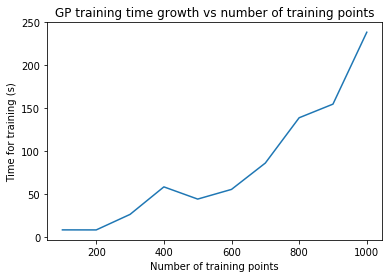

In [26]:
plt.plot(train_sizes[:10], emu_train_times[:10])
plt.title("GP training time vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for training (s)")
plt.show()

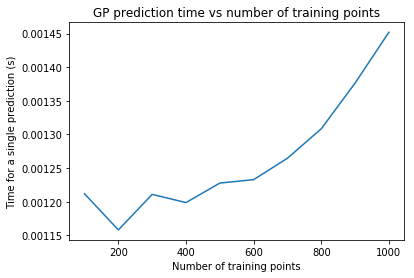

In [27]:
plt.plot(train_sizes[:10], emu_prediction_times[:10])
plt.title("GP prediction time vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for a single prediction (s)")
plt.show()

## Emulator vs Model

In [ ]:
#kern = GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters)
#kern += GPy.kern.White(n_parameters)
train_input = log_prior.sample(4000)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_input)
emu = emupints.GPEmulator(real_log_likelihood, train_input, train_target, normalize_input = True)

In [ ]:
emu.set_parameters(kernel = kernels[5])
emu.fit(messages = False, normalizer = True)
emu.get_gp()

In [ ]:
emu_posterior = pints.LogPosterior(emu, log_prior)
model_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [ ]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]

In [ ]:
xs

In [ ]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(20000)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

In [ ]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(20000)
model_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

In [ ]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

In [ ]:
pints.plot.trace(model_chains)
plt.show()

In [ ]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

In [ ]:
model_prediction

In [ ]:
diffs = np.abs(model_prediction - emu_prediction)

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

A strong limitation to performance is the size of the training set. If sample uniformly over parameter space the results appear horrible even with high number of training points. Instead, we should sample mostly from high-likelihood areas as they are the ones that are likely to be used by MCMC. 

## post-MCMC emulation

In [ ]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(2000)
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

In [ ]:
pints.plot.trace(model_chains)
plt.show()

In [ ]:
# use small progress in MCMC to derive our train set
train_points = model_chains.reshape((model_chains.size // 3, 3))
train_target = np.apply_along_axis(real_log_likelihood, 1, train_points).flatten()

In [ ]:
emu = emupints.GPEmulator(real_log_likelihood, train_points, train_target, normalize_input = True)
emu.set_parameters(kernel = best_kern)
emu.fit(messages = False, normalizer = True)
emu_posterior = pints.LogPosterior(emu, log_prior)

In [ ]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(10000)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

In [ ]:
pints.plot.trace(emu_chains)
plt.show()

In [ ]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

In [ ]:
fig, axes = emuplt.plot_fixed_param_grid(emu, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         contour = False,
                                         shape = (3, 3),
                                         additional_log_likelihoods = [real_log_likelihood]
                              )